# Logistic Regression for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [1]:
import pandas as pd
# if you want to download the original file:
#df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


Let us shuffle the class labels.

In [2]:
import numpy as np
## uncomment these lines if you have dowloaded the original file:
#np.random.seed(0)
#df = df.reindex(np.random.permutation(df.index))
#df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)

<br>
<br>

## Preprocessing Text Data

Now, let us define a simple `tokenizer` that splits the text into individual word tokens. Furthermore, we will use some simple regular expression to remove HTML markup and all non-letter characters but "emoticons," convert the text to lower case, remove stopwords, and apply the Porter stemming algorithm to convert the words into their root form.

In [3]:
import numpy as np
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return text

Let's give it at try:

In [4]:
tokenizer('This :) is a <a> test! :-)</br>')

['test', ':)', ':)']

## Learning (SciKit)

First, we define a generator that returns the document body and the corresponding class label:

In [5]:
#funcion generadora: retorna el texto y la clase (fila del dataset)
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To conform that the `stream_docs` function fetches the documents as intended, let us execute the following code snippet before we implement the `get_minibatch` function:

In [6]:
doc_stream = stream_docs(path='shuffled_movie_data.csv')
#next(doc_stream)
#next(doc_stream)

After we confirmed that our `stream_docs` functions works, we will now implement a `get_minibatch` function to fetch a specified number (`size`) of documents:

In [7]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

Next, we will make use of the "hashing trick" through scikit-learns [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) to create a bag-of-words model of our documents. Details of the bag-of-words model for document classification can be found at  [Naive Bayes and Text Classification I - Introduction and Theory](http://arxiv.org/abs/1410.5329).

In [8]:
from sklearn.feature_extraction.text import HashingVectorizer
vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

# Excercise 1: define new features according to https://web.stanford.edu/~jurafsky/slp3/5.pdf
type(vect)
print(vect)

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='ignore', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=2097152, ngram_range=(1, 1), non_negative=False,
         norm='l2', preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=<function tokenizer at 0x7f3f63a328c8>)


Using the [SGDClassifier]() from scikit-learn, we will can instanciate a logistic regression classifier that learns from the documents incrementally using stochastic gradient descent. 

In [9]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', random_state=1, n_iter=1)
doc_stream = stream_docs(path='shuffled_movie_data.csv')

#X_train, y_train = get_minibatch(doc_stream, size=5)
#vv=vect.transform(X_train)
#vv = vv.todense()
#print(X_train)
#vv.shape
# Excercise 2: implement a Logistic Regression classifier, using regularization, according to https://web.stanford.edu/~jurafsky/slp3/5.pdf

In [10]:
#import pyprind
#pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    #obtener submuestra de 1000 textos (1000 filas)
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    #pbar.update()


/home/david/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/david/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/david/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/david/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/david/anaconda3/lib/python3.7/site-pac

/home/david/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/david/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/david/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/david/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/david/anaconda3/lib/python3.7/site-pac

In [11]:
#X_train, y_train = get_minibatch(doc_stream, size=5)

Depending on your machine, it will take about 2-3 minutes to stream the documents and learn the weights for the logistic regression model to classify "new" movie reviews. Executing the preceding code, we used the first 45,000 movie reviews to train the classifier, which means that we have 5,000 reviews left for testing:

In [12]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))
#clf.predict(X_test)
#X_test

Accuracy: 0.867


I think that the predictive performance, an accuracy of ~87%, is quite "reasonable" given that we "only" used the default parameters and didn't do any hyperparameter optimization. 

After we estimated the model perfomance, let us use those last 5,000 test samples to update our model.

In [13]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, clf.)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

SyntaxError: invalid syntax (<ipython-input-13-70c8a4bb7ba7>, line 2)

In [ ]:
clf = clf.partial_fit(X_test, y_test)

<br>
<br>

# Model Persistence

In the previous section, we successfully trained a model to predict the sentiment of a movie review. Unfortunately, if we'd close this IPython notebook at this point, we'd have to go through the whole learning process again and again if we'd want to make a prediction on "new data."

So, to reuse this model, we could use the [`pickle`](https://docs.python.org/3.5/library/pickle.html) module to "serialize a Python object structure". Or even better, we could use the [`joblib`](https://pypi.python.org/pypi/joblib) library, which handles large NumPy arrays more efficiently.

To install:
conda install -c anaconda joblib

In [ ]:
import joblib
import os
if not os.path.exists('./pkl_objects'):
    os.mkdir('./pkl_objects')
    
joblib.dump(vect, './vectorizer.pkl')
joblib.dump(clf, './clf.pkl')

Using the code above, we "pickled" the `HashingVectorizer` and the `SGDClassifier` so that we can re-use those objects later. However, `pickle` and `joblib` have a known issue with `pickling` objects or functions from a `__main__` block and we'd get an `AttributeError: Can't get attribute [x] on <module '__main__'>` if we'd unpickle it later. Thus, to pickle the `tokenizer` function, we can write it to a file and import it to get the `namespace` "right".

In [ ]:
%%writefile tokenizer.py
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return text

In [ ]:
from tokenizer import tokenizer
joblib.dump(tokenizer, './tokenizer.pkl')

Now, let us restart this IPython notebook and check if the we can load our serialized objects:

In [ ]:
import joblib
tokenizer = joblib.load('./tokenizer.pkl')
vect = joblib.load('./vectorizer.pkl')
clf = joblib.load('./clf.pkl')

After loading the `tokenizer`, `HashingVectorizer`, and the tranined logistic regression model, we can use it to make predictions on new data, which can be useful, for example, if we'd want to embed our classifier into a web application -- a topic for another IPython notebook.

In [ ]:
example = ['I did not like this movie']
X = vect.transform(example)
clf.predict(X)

In [ ]:
example = ['I loved this movie']
X = vect.transform(example)
clf.predict(X)

## Ejercicio 1: Caracteristicas TF-IDF 

Metodo basado en frecuencias y que mide la relevancia de una palabra para un documento en un dataset.
- TF(Term Frecuency): frecuencia de un termino en un documento.
- IDF(Inverse Document Frecuency): medida de un termino comun en un conjunto de documentos

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import array

doc_stream = stream_docs(path='shuffled_movie_data.csv')

#conjunto de entrenamiento (entrenamiento: 45000 ejemplos)
X_train_full, y_train_full = get_minibatch(doc_stream, size=45000)

#conjunto de test
X_test_full, y_test = get_minibatch(doc_stream, size=5000)
#objeto-configuracion
vectorizer = TfidfVectorizer (max_df=0.90, min_df=2, sublinear_tf = True, use_idf = True, stop_words = 'english')

#transformaciones
X_train_tfidf = vectorizer.fit_transform(X_train_full)
X_test_tfidf = vectorizer.transform(X_test_full)


In [63]:
print('X train size: ',X_train_tfidf.shape)
print('X train size: ',X_test_tfidf.shape)

X train size:  (45000, 57102)
X train size:  (5000, 57102)


In [ ]:
#print(X_train_tfidf)

In [ ]:
#print(X_test_tfidf)

## Ejercicio 2: Regresion Logistica (Implementacion propia)

In [64]:

#print('X train size:',X_train_tfidf.shape)
#print('y train size:',type(X_train_tfidf))

type(X_train_tfidf)
type(y_train_full)

#convertir a matrices numpy
#X_matrix = X_train_tfidf.todense()
y_matrix = array(y_train_full)
y_matrix= y_matrix.reshape(y_matrix.shape[0],1)

#X_matrix.shape
(y_matrix.shape)

(45000, 1)

In [65]:
from scipy.special import expit #Vectorized sigmoid function


#funcion sigmoide
def sigmoide(z):
    return expit(z)

#hipotesis
def h(theta,X): # X(n_examples x n_features), theta(n_features x 1) 
    return sigmoide(np.dot(X,theta))# (n_examples x 1)

#funcion de costo - regularizado
def computeCost(theta,X,y,m,lamb):
    h_tmp = h(theta,X)#(n_examples x 1)
    #print('h_tmp: ',h_tmp.shape)
    op1 = -np.dot(np.transpose(y),np.log(h_tmp)) # y': 1 x n_examples, log(n_examples x 1) = 1 x 1 
    op2 = np.dot(np.transpose(1-y),np.log(1-h_tmp))# (1-y)': 1 x n_examples, log(n_examples x 1) = 1 x 1 
    regular_term = (lamb/(2*m))*(np.sum(np.square(theta))) #regularizacion
    cost = (1/m)*(op1-op2)+regular_term #1 x 1
    #print('e1: ',op1.shape)
    #print('e2: ',op2.shape)
    return cost 

#gradiente descendente
def gradienteDescendente(initial_theta,X,y,alpha,n_iter,m,lamb):
    theta = initial_theta;
    jvec = [] #Used to plot cost as function of iteration
    print('initial theta: ',theta.shape)
    for _ in range(n_iter):
        theta_i = computeCost(theta,X,y,m,lamb)
        jvec.append(theta_i.item())
        #print('cost: ',type(theta_i))
        reg_term = (lamb/m)*theta #n_features x 1
        theta = theta - (alpha/m)*(np.dot(np.transpose(X),(h(theta,X)-y))) + reg_term
        # n_features x 1 - dot(n_features x n_examples; n_examples x 1)
        # n_features x 1 - dot(n_features x 1)
        
    return theta, jvec

#minibach gradiente descendente
    
def minibatchGradient(epocas, batch_size,X_sparce,y_array,initial_theta,alpha,n_iter,m,lamb):
    #for ep in range(epocas):
    theta = initial_theta;
    jvec = [] #Used to plot cost as function of iteration
    j=0
    
    for i in range(0, m, batch_size):   
        j=j+1
        X_train_mini = array((X_sparce[i:i + batch_size,:]).todense())
        y_train_mini = y_array[i:i + batch_size]
        #print('X_mini: ',X_train_mini.shape)
        #print('y_mini: ',y_train_mini.shape)
        #print('ii: ',j)
        for _ in range(n_iter):
            theta_i = computeCost(theta,X_train_mini,y_train_mini,m,lamb)
            jvec.append(theta_i.item())
            reg_term = (lamb/batch_size)*theta #n_features x 1
            theta = theta - (alpha/batch_size)*(np.dot(np.transpose(X_train_mini),(h(theta,X_train_mini)-y_train_mini))) + reg_term
    return theta, jvec


#Plot convergencia de gradiente
import matplotlib.pyplot as plt # plot visualization

def plotConvergence(jvec,iterations):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(jvec)),jvec,'bo')
    plt.grid(True)
    plt.title("Convergencia de MiniBatch - Gradiente Descendente")
    plt.xlabel("Numero de Iteraciones")
    plt.ylabel("Funcion de Costo")
    dummy = plt.xlim([-0.05*iterations,1.05*iterations])
    #dummy = plt.ylim([4,8])

In [69]:
#Configuracion de parametros para el algoritmo
#########################################################

n_examples = y_matrix.shape[0]
n_features = X_train_tfidf.shape[1]
print('n° ejemplos: ',n_examples)
print('n° caracteristicas: ',n_features)

#Test minibatch
# num de batchs
ephocs = 100
# batch size
batch_size = 450
alpha=0.1
# num de iteraciones
n_iter = 10
#initial_theta
initial_theta = np.zeros((n_features,1))#(8564x1)

#parametro de regularizacion
lamb=1




n° ejemplos:  45000
n° caracteristicas:  57102


## Entrenamiento del modelo

In [70]:
#minibatchGradient(ephocs, batch_size,X_train_tfidf,y_matrix,n_examples)
theta, jvec = minibatchGradient(ephocs, batch_size,X_train_tfidf,y_matrix,initial_theta,alpha,n_iter,n_examples,lamb)

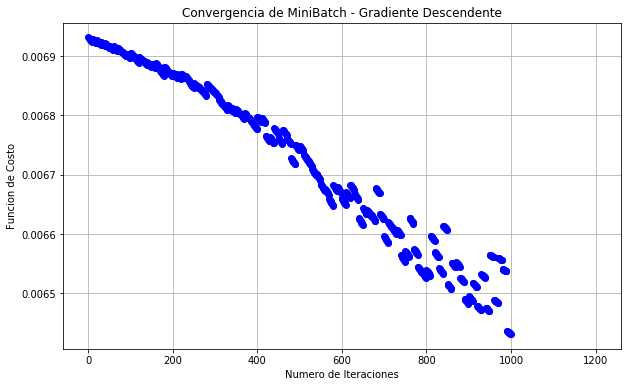

In [72]:
#verificacion de convergencia del algoritmo implementado
plotConvergence(jvec,1200)

## Testing - Evaluacion del modelo

In [73]:
#Realizando predicciones
#prediciones = h(theta,X_test_tfidf)
theta.shape, X_test_tfidf.shape
#X_test = array(X_test_tfidf.todense())

def predicciones(epocas, batch_size,X_sparce,final_theta,m):
    #for ep in range(epocas):
    #pp=[]
    X_train_mini = array((X_sparce[0:batch_size,:]).todense())
    prob = h(theta,X_train_mini)
    #print(type(tt))
    #print(tt)
    for i in range(batch_size, m, batch_size): 
        X_train_mini = array((X_sparce[i:i + batch_size,:]).todense())
        #y_train_mini = y_array[i:i + batch_size]
        prob = np.concatenate((prob,h(theta,X_train_mini)),axis=None)
    
    predictions = np.zeros(m)
    for j in range (0,len(prob),1):
        if prob[j] >= 0.5:
            predictions[j]=1
    return prob, predictions


    

In [74]:
#calcular predicciones por batch
# num de batchs
ephocs = 5
# batch size
batch_size = 1000
prob, predictions = predicciones(ephocs,batch_size,X_test_tfidf,theta,X_test_tfidf.shape[0])

## Exactitud

In [75]:
#Calculando accuracy
y_test_matrix = array(y_test)
y_test_matrix= y_test_matrix.reshape(y_test_matrix.shape[0],1)
from sklearn.metrics import accuracy_score
accuracy_score(y_test_matrix, predictions)

0.8136

## Curva de ROC - AUC

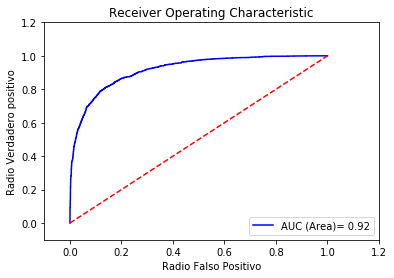

In [78]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_matrix, prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC (Area)= %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('Radio Verdadero positivo')
plt.xlabel('Radio Falso Positivo')
plt.show()